Epoch 1/6
582/582 - 100s - loss: 0.0361 - accuracy: 0.9903 - val_loss: 0.0188 - val_accuracy: 0.9948 - 100s/epoch - 172ms/step
Epoch 2/6
582/582 - 92s - loss: 0.0192 - accuracy: 0.9934 - val_loss: 0.0288 - val_accuracy: 0.9923 - 92s/epoch - 157ms/step
Epoch 3/6
582/582 - 91s - loss: 0.0153 - accuracy: 0.9952 - val_loss: 0.0169 - val_accuracy: 0.9946 - 91s/epoch - 156ms/step
Epoch 4/6
582/582 - 91s - loss: 0.0125 - accuracy: 0.9962 - val_loss: 0.0177 - val_accuracy: 0.9946 - 91s/epoch - 156ms/step
Epoch 5/6
582/582 - 94s - loss: 0.0115 - accuracy: 0.9962 - val_loss: 0.0303 - val_accuracy: 0.9920 - 94s/epoch - 162ms/step
Epoch 6/6
582/582 - 91s - loss: 0.0114 - accuracy: 0.9959 - val_loss: 0.0215 - val_accuracy: 0.9933 - 91s/epoch - 156ms/step


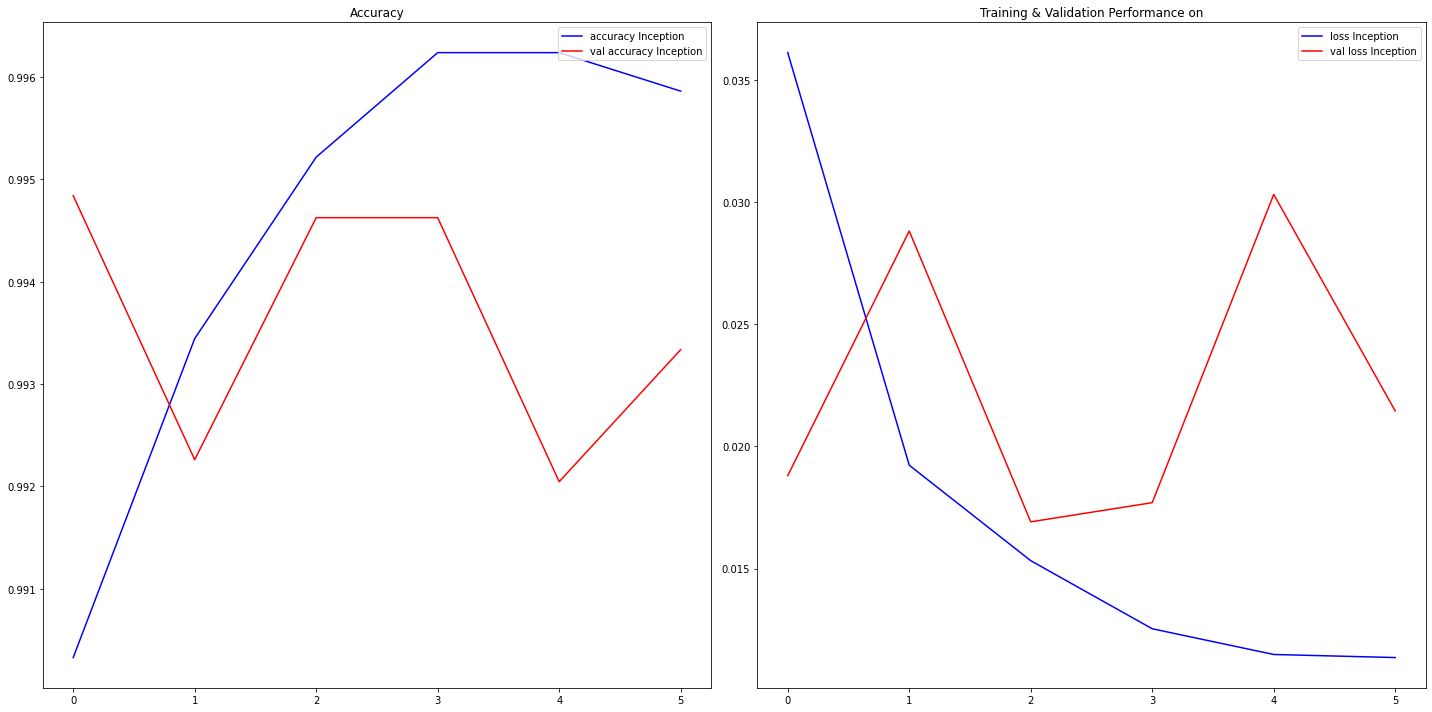

1/1 - 1s - loss: 0.0340 - accuracy: 1.0000 - 842ms/epoch - 842ms/step
./1663448741.h5
'~'   1663448741.h5   sample_data


In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import time
import matplotlib.pyplot as plt

(train_data, val_data), meta = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'], 
                                                        with_info=True, as_supervised=True)

num_train=meta.splits['train'].num_examples
BATCH=32
EPOCHS=6

def define_model():
    #MobileNet
    #RES=224
    #URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

    #Inception
    RES=299
    URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
    model=tf.keras.Sequential([
        hub.KerasLayer(URL, input_shape=(RES, RES, 3)),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam())
    return model, RES
model,RES=define_model()

def preprocess_batches():
    normalize=lambda data, labels: (tf.image.resize(data, (RES, RES))/255.0, labels)
    train_batch = train_data.shuffle(num_train//4).map(normalize).batch(BATCH).prefetch(tf.data.AUTOTUNE)
    val_batch = val_data.map(normalize).batch(BATCH).prefetch(tf.data.AUTOTUNE)
    return train_batch, val_batch

train_batch, val_batch = preprocess_batches()
history=model.fit(
    train_batch,
    verbose=2,
    validation_data=val_batch,
    epochs=EPOCHS
)

def summarize_model_diagnostics(history):
    loss, acc = history.history['loss'], history.history['accuracy']
    val_loss, val_acc = history.history['val_loss'], history.history['val_accuracy']
    fig, ax=plt.subplots(1,2, figsize=(20,10))
    ax[1].plot(loss, label='loss Inception',color='blue')
    ax[1].plot(val_loss, label='val loss Inception', color='r')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Loss')

    ax[0].plot(acc, label='accuracy Inception',color='blue')
    ax[0].plot(val_acc, label='val accuracy Inception', color='r')
    ax[0].legend(loc='upper right')
    ax[0].set_title('Accuracy')
    plt.title('Training & Validation Performance on')
    plt.tight_layout()
    plt.show()

summarize_model_diagnostics(history)
test_data, test_labels = next(iter(train_batch.take(1)))
test_data, test_labels = test_data.numpy(), test_labels.numpy()

predicts = model.evaluate(test_data, test_labels, verbose=2, batch_size=BATCH)
#predicted_label = np.argmax(tf.squeeze(predicts).numpy(), axis=-1)

t = time.time()

export_path_keras = "./{}.h5".format(int(t))
model.save(export_path_keras)
print((export_path_keras))
!ls



In [14]:
reloaded = tf.keras.models.load_model(
    export_path_keras,
    custom_objects={'KerasLayer': hub.KerasLayer}
)
result_rl=reloaded.predict(test_data, verbose=2)
result=model.predict(test_data, verbose=2)
dif=(result_rl-result).max()
print(dif)

reloaded.fit(train_batch, batch_size=BATCH, epochs=3, validation_data=val_batch)
result_rl=reloaded.predict(test_data, verbose=2)
dif=(result_rl-result).max()
print(dif)

1/1 - 1s - 1s/epoch - 1s/step
1/1 - 0s - 108ms/epoch - 108ms/step
0.0
Epoch 1/3
582/582 [==============================] - 97s 154ms/step - loss: 0.0094 - accuracy: 0.9971 - val_loss: 0.0193 - val_accuracy: 0.9944
Epoch 2/3
582/582 [==============================] - 97s 156ms/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.0203 - val_accuracy: 0.9940
Epoch 3/3
582/582 [==============================] - 93s 153ms/step - loss: 0.0070 - accuracy: 0.9976 - val_loss: 0.0207 - val_accuracy: 0.9942
1/1 - 0s - 76ms/epoch - 76ms/step
0.22593045


In [23]:
t=time.time()
export_path="./{}".format(int(t))
model.save(export_path)
!ls {export_path}

assets	keras_metadata.pb  saved_model.pb  variables


In [24]:

model_hub = tf.keras.models.load_model(
    export_path,
    custom_objects={'KerasLayer': hub.KerasLayer}
)
model_hub.summary()

!zip -r model.zip {export_path}
!ls
try:
  from google.colab import files
  #files.download("./model.zip")
except:
  pass




Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_5 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________
  adding: 1663451087/ (stored 0%)
  adding: 1663451087/assets/ (stored 0%)
  adding: 1663451087/variables/ (stored 0%)
  adding: 1663451087/variables/variables.index (deflated 81%)
  adding: 1663451087/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: 1663451087/saved_model.pb (deflated 93%)
  adding: 1663451087/keras_metadata.pb (deflated 80%)
'~'		 1663450613   1663451087   sample_data
 1663448741.h5	 1663450812   